In [369]:
from bs4 import BeautifulSoup
from glob import glob
import re
from functools import wraps
import shutil
import os
import json

# stolen from Render Anon
EDGE_TOKENIZER = re.compile(
    r"""
[!|/[\]]                |   # Move to, line to, quad to
(?<!S)-?\d+(?:\.\d+)?   |   # Decimal number
\#[A-Z0-9]+\.[A-Z0-9]+      # Hex number
""",
    re.VERBOSE,
)

# stolen from Render Anon
def _pe_parse_number(num: str) -> float:
    """Parse an XFL edge format number."""
    if num[0] == "#":
        # Signed, 32-bit number in hex
        parts = num[1:].split(".")
        # Pad to 8 digits
        hex_num = "{:>06}{:<02}".format(*parts)
        num = int.from_bytes(bytes.fromhex(hex_num), "big", signed=True)
        # Account for hex scaling and Animate's 20x scaling
        return (num / 256) / 20
    else:
        # Decimal number. Account for Animate's 20x scaling
        return float(num) / 20

# stolen from Render Anon
def _pe_edge_format_to_point_lists(edges: str):
    """Convert the XFL edge format to point lists.

    Args:
        edges: The "edges" attribute of an XFL <Edge> element

    Yields:
        One point list for each segment parsed out of `edges`
    """
    tokens = iter(EDGE_TOKENIZER.findall(edges))

    def next_point():
        return [_pe_parse_number(next(tokens)), _pe_parse_number(next(tokens))]

    assert next(tokens) == "!", "Edge format must start with moveto (!) command"

    prev_point = next_point()
    point_list = [prev_point]

    try:
        while True:
            command = next(tokens)
            curr_point = next_point()

            if command == "!":
                # Move to
                if curr_point != prev_point:
                    # If a move command doesn't change the current point, we
                    # can ignore it. Otherwise, we must yield the current point
                    # list and begin a new one.
                    yield point_list
                    point_list = [curr_point]
                    prev_point = curr_point
            elif command in "|/":
                # Line to
                point_list.append(curr_point)
                prev_point = curr_point
            else:
                # Quad to. The control point (curr_point) is marked by putting
                # it in a tuple.
                point_list.append((curr_point,))
                prev_point = next_point()
                point_list.append(prev_point)
    except StopIteration:
        yield point_list
    
def _sb_parse_coordinates(coord):
    x, y = coord.split(', ')
    return [
        # these hex numbers don't get scaled by 256 like others
        _pe_parse_number(x) * 256,
        _pe_parse_number(y) * 256,
    ]

def _sb_parse_index(index):
    if index == None:
        return None
    return int(index)
    
def _sb_parse_morph_segment(segment):
    result = {
        'startPointA': _sb_parse_coordinates(segment.get('startPointA', None)),
        'startPointB': _sb_parse_coordinates(segment.get('startPointB', None)),
        'strokeIndex1': _sb_parse_index(segment.get('strokeIndex1', None)),
        'strokeIndex2': _sb_parse_index(segment.get('strokeIndex2', None)),
        'fillIndex1': _sb_parse_index(segment.get('fillIndex1', None)),
        'fillIndex2': _sb_parse_index(segment.get('fillIndex2', None)),
        'curves': []
    }
    
    for curve in segment.findChildren('MorphCurves', recursive=False):
        result['curves'].append([
            _sb_parse_coordinates(curve['controlPointA']),
            _sb_parse_coordinates(curve['anchorPointA']),
            _sb_parse_coordinates(curve['controlPointB']),
            _sb_parse_coordinates(curve['anchorPointB']),
            curve.get("isLine", None),
        ])
    
    return result

def _sb_parse_hint(hint):
    return [
        _sb_parse_coordinates(hint['startPoint']),
        _sb_parse_coordinates(hint['endPoint'])
    ]

def _sb_get_morph_data(domframe):
    segments = []
    hints = []
    shapes = []

    if domframe.morphSegments:
        segments = [
            _sb_parse_morph_segment(x)
            for x in domframe.morphSegments.findChildren('MorphSegment')
        ]
    
    for hintlist in domframe.findChildren('morphHintsList', recursive=False):
        nextHints = hintlist.findChildren('MorphHint')
        if hints and nextHints:
            print('found multiple morphHintsList nodes')
        hints = [_sb_parse_hint(x) for x in nextHints]
    
    for shape in domframe.elements.findChildren(recursive=False):
        
        fills = {}
        strokes = {}
        edges = []
        
        if shape.name == 'DOMShape':
            for style in shape.findChildren('FillStyle'):
                index = _sb_parse_index(style.get('index', 1))
                color = style.SolidColor['color']
                fills[index] = color
            for style in shape.strokes.findChildren('StrokeStyle'):
                index = _sb_parse_index(style.get('index', 1))
                color = style.SolidStroke.fill.SolidColor['color']
                strokes[index] = color
            for edge in shape.edges.findChildren('Edge'):
                if not edge.get('edges', None):
                    continue

                edges.append({
                    'fillStyle0': _sb_parse_index(edge.get('fillStyle0', None)),
                    'fillStyle1': _sb_parse_index(edge.get('fillStyle1', None)),
                    'strokeStyle': _sb_parse_index(edge['strokeStyle']),
                    'points': list(_pe_edge_format_to_point_lists(edge['edges'])),
                })
        elif shape.name == 'DOMRectangleObject':
            print(shape.fill)
            for style in shape.findChildren('fill', recursive=False):
                index = _sb_parse_index(style.get('index', 1))
                color = style.SolidColor['color']
                fills[index] = color
            for style in shape.findChildren('stroke'):
                index = _sb_parse_index(style.get('index', 1))
                color = style.SolidStroke.fill.SolidColor['color']
                strokes[index] = color
            
            # create edge list for the rectangle
            width = float(shape.get('objectWidth'))
            height = float(shape.get('objectHeight'))
            x = float(shape.get('x'))
            y = float(shape.get('y'))
            
            rectangle = {}
            if len(fills) > 0:
                rectangle['fillStyle1'] = next(iter(fills))
            if len(strokes) > 0:
                rectangle['strokeStyle'] = next(iter(strokes))
            rectangle['points'] = [[
                [x, y], [x+width, y], [x+width, y+height], [x, y+height], [x,y]
            ]]
            
            print(rectangle)
            edges.append(rectangle)

        shapes.append({
            'fills': fills,
            'strokes': strokes,
            'edges': edges
        })
            
    
    return segments, hints, shapes

def _sb_load_testfile(testName):
    docPath = fr'C:\Users\synthbot\animate-tools\output\ShapeTweens\{testName}.xml'
    with open(docPath) as docFile:
        return BeautifulSoup(docFile, 'xml')

def _sb_generated_list(fn):
    @wraps(fn)
    def result(*args, **kwargs):
        return list(fn(*args, **kwargs))
    return result

@_sb_generated_list
def loadDOMDocument(testName):
    testFile = _sb_load_testfile(testName)
    
    for frame in testFile.findChildren('DOMFrame'):
        segments, hints, shapes = _sb_get_morph_data(frame)
        yield {
            'testName': testName,
            'index': int(frame['index']),
            'duration': int(frame.get('duration', 1)),
            'segments': segments,
            'hints': hints,
            'shapes': shapes,
        }


def getTestData():
    result = {}
    
    inputFiles = (
        set(glob(fr'C:\Users\synthbot\animate-tools\output\ShapeTweens\*'))
        - set(glob(fr'C:\Users\synthbot\animate-tools\output\ShapeTweens\truth-*'))
    )
    inputFiles = [os.path.splitext(os.path.basename(x))[0] for x in inputFiles]
    fileMapping = dict(
        (x, f'truth-{x}') for x in inputFiles
    )
    
    for testInputName, testTruthName in fileMapping.items():
        testInputData = loadDOMDocument(testInputName)
        testTruthData = loadDOMDocument(testTruthName)
        
        for frame in testTruthData:
            del frame['segments']
            del frame['hints']
        
        result[testInputName] = {
            'tweenInfo': testInputData,
            'groundTruth': testTruthData
        }
    
    return result

data = getTestData()
with open('shapetweens.json', 'w') as output:
    output.write(json.dumps(data))


<fill>
<SolidColor color="#00FF00"/>
</fill>
{'fillStyle1': 1, 'strokeStyle': 1, 'points': [[[281.05, 252.95], [448.0, 252.95], [448.0, 381.95], [281.05, 381.95], [281.05, 252.95]]]}
<fill>
<SolidColor color="#00FF00"/>
</fill>
{'fillStyle1': 1, 'strokeStyle': 1, 'points': [[[281.05, 252.95], [448.0, 252.95], [448.0, 381.95], [281.05, 381.95], [281.05, 252.95]]]}


The output should look like this:
~~~
[
        {
            'duration': 1,
            'shapes': [
                'fills': {'1': '#00FF00'},
                'strokes': {'1': '#00CC66'},
                'edges': [
                    'fillStyle0': None,
                    'fillStyle1': '1',
                    'points': [[
                          [364.6, 258.6], # non-control point
                          [[508.35, 306.25]], # control point
                          ...
                    ]]
                ]
            ]
        },
        {
            ...
        },
        ...
    ]
~~~    
    duration: integer (example: 1)
    Shape data: { fills, strokes, edges }
    Fill data: 'fills': { fillId: color }
     - Example: { '1': '#00FF00' }
    Stroke data: 'strokes': { strokeId: color }
     - Example: { '1': '#00CC66' }
    Edge data: 'edges': array of { fillStyle0, fillStyle1, strokeStyle, array of points }
    fillStye0: fill data index (e.g., 'fillStyle0': '1')
    fillStyle1: fill data index (e.g., 'fillStyle1': '1')
    strokeStyle: stroke data index (e.g., 'strokeStyle': '1')
    point: [x, y] or [[x, y]]
     - Example: [521.0, 366.4]
     - Example: [[521.0, 366.4]]

In [257]:
from matplotlib import pyplot as plt


class Variable:
    def _wrap_io(fn):
        def wrapped_fn(self, other):
            if not callable(other):
                result = fn(self, lambda x: other)
            else:
                result = fn(self, other)
            return Variable(result)

        return wrapped_fn

    def __init__(self, fn=lambda x: x):
        self.fn = fn

    @_wrap_io
    def __add__(self, other):
        return lambda x: self(x) + other(x)

    @_wrap_io
    def __radd__(self, other):
        return lambda x: other(x) + self(x)

    @_wrap_io
    def __sub__(self, other):
        return lambda x: self(x) - other(x)

    @_wrap_io
    def __rsub__(self, other):
        return lambda x: other(x) - self(x)

    @_wrap_io
    def __mul__(self, other):
        return lambda x: self(x) * other(x)

    @_wrap_io
    def __rmul__(self, other):
        return lambda x: other(x) * self(x)

    def __call__(self, val):
        return self.fn(val)


class Point:
    def __init__(self, x=0, y=0) -> None:
        self.x = x
        self.y = y

    def __repr__(self):
        return f"{self.x, self.y}"


class Line:
    def __init__(self, p1, p2) -> None:
        self.p1 = p1
        self.p2 = p2

    def __call__(self, t):
        x = (self.p2.x - self.p1.x) * t + self.p1.x
        y = (self.p2.y - self.p1.y) * t + self.p1.y
        return Point(x, y)


def segments(points):
    return [Line(x, y) for x, y in zip(points[:-1], points[1:])]


class Bezier:
    def __init__(self, points):
        t = Variable()
        while len(points) > 1:
            points = [x(t) for x in segments(points)]
        self.eqn = points[0]

    def __call__(self, t):
        return Point(self.eqn.x(t), self.eqn.y(t))

    def plot(self):
        pts = [self(t / 100) for t in range(100)]
        x = [p.x for p in pts]
        y = [p.y for p in pts]
        plt.plot(x, y, "k.")
        plt.show


class BezierPath:
    def __init__(self, points):
        self.curves = []
        self.pts = []
        # every set of 4 points forms a bezier curve through the outer 2 points
        # so each intermediate point introduces 3 curve "points"
        for i in range(0, len(points) - 2, 3):
            self.curves.append(Bezier(points[i : i + 4]))
            self.pts.append(points[i])
        self.pts.append(points[-1])

    def __call__(self, t):
        if len(self.curves) == 1:
            return self.curves[0](t)

        for i in range(len(self.pts)):
            if self.pts[i].x >= t:
                break

        if self.pts[i].x == t:
            return self.pts[i]

        frac = (t - self.pts[i - 1].x) / (self.pts[i].x - self.pts[i - 1].x)
        return self.curves[i - 1](frac)


    def plot(self):
        pts = []
        startX = self.pts[0].x
        endX = self.pts[-1].x
        print(self.pts)
        for i in range(1000):
            frac = i / 1000
            pts.append(self(startX + i*(endX - startX)))

        pts = [self(t / 1000) for t in range(1000)]
        x = [p.x for p in pts]
        y = [p.y for p in pts]
        plt.figure()
        plt.plot(x, y, "k.")
        plt.show()
        plt.close()



In [333]:
from matplotlib import pyplot as plt
from functools import reduce
import math

def _gt(tweenInfo):
    result = []
    
    start = tweenInfo['index']
    duration = tweenInfo['duration']
    required_frames = set(range(start, start + duration))
    
    for gt in data[tweenInfo['testName']]['groundTruth']:
        if gt['index'] in required_frames:
            result.append(gt)

    return result

def groundtruth(tweenInfo):
    frames = _gt(tweenInfo[0])
    frames.extend(_gt(tweenInfo[1]))
    return [x['shapes'] for x in frames]
    
def test_tweens(fn, tweenInfo):
    generated = fn(frame)
    expected = [x['shapes'] for x in _sb_get_groundtruth(tweenInfo)]

def _sb_plot(figure, title, i, value):
    plt.figure(figure)
    plt.title(title)
    plt.plot(i, value, 'k.')

def split_colors(color):
    if not color:
        return 0, 0, 0
    if not color.startswith('#'):
        raise Exception(f'invalid color: {color}')
    assert len(color) == 7
    r = int(color[1:3], 16)
    g = int(color[3:5], 16)
    b = int(color[5:7], 16)
    return r, g, b
    
def get_shape_features(shape):
    result = {
        'x': [],
        'y': [],
        'controls': [],
        'fillStyle0 red': [],
        'fillStyle0 green': [],
        'fillStyle0 blue': [],
        'fillStyle1 red': [],
        'fillStyle1 green': [],
        'fillStyle1 blue': [],
        'strokeStyle red': [],
        'strokeStyle green': [],
        'strokeStyle blue': [],
    }
    
    for edge in shape['edges']:
        color = edge.get('fillStyle0', None)
        if color:
            color = shape['fills'][color]
        r, g, b = split_colors(color)
        result['fillStyle0 red'].append(r)
        result['fillStyle0 green'].append(g)
        result['fillStyle0 blue'].append(b)
        
        color = edge.get('fillStyle1', None)
        if color:
            color = shape['fills'][color]
        r, g, b = split_colors(color)
        result['fillStyle1 red'].append(r)
        result['fillStyle1 green'].append(g)
        result['fillStyle1 blue'].append(b)
        
        color = edge.get('strokeStyle', None)
        if color:
            color = shape['strokes'][color]
        r, g, b = split_colors(color)
        result['strokeStyle red'].append(r)
        result['strokeStyle green'].append(g)
        result['strokeStyle blue'].append(b)
        
        for pt in edge['points'][0]:
            if len(pt) == 1:
                result['controls'].append(1)
                pt = pt[0]
            else:
                result['controls'].append(0)
            result['x'].append(pt[0])
            result['y'].append(pt[1])
    
    return result        


def concat(arr):
    return reduce(lambda x,y: x+y, arr)

def compare_seqs(generated_list, truth_list):
    assert len(generated_list) == len(truth_list)
    diff = {}
    frameIndex = 0
    
    for generated_features, truth_features in zip(generated_list, truth_list):
        for key in truth_features:
            diff[key] = list(map(
                lambda x,y: x-y, truth_features[key], generated_features[key]
            ))
            length = len(diff[key])
            delta = 1 / length
            offsets = [frameIndex + delta*i for i in range(length)]
            
            _sb_plot(key, key, offsets, diff[key])
        frameIndex += 1

def compare_shapes(generated, truth):
    generated_features = [get_shape_features(x) for x in generated]
    truth_features = [get_shape_features(x) for x in truth]
    compare_seqs(generated_features, truth_features)
    
def compare_framesets(generated, truth):
    generated_features = []
    for i, frame in enumerate(generated):
        for shape in frame:
            generated_features.append(get_shape_features(shape))

    truth_features = []
    for frame in truth:
        for shape in frame:
            truth_features.append(get_shape_features(shape))

    compare_seqs(generated_features, truth_features)

def interpolate_value(x, y, idx, duration):
    interp = idx / (duration - 1)
    result = (1-interp)*x + interp*y
    return result
    
def interpolate_color(x, y, i, duration):
    rx, gx, bx = split_colors(x)
    ry, gy, by = split_colors(y)
    ri = round(interpolate_value(rx, ry, i, duration))
    gi = round(interpolate_value(gx, gy, i, duration))
    bi = round(interpolate_value(bx, by, i, duration))
    return '#%02X%02X%02X' % (ri, gi, bi)
    
def interpolate_shapes(initial, final, duration):
    result = []
    for i in range(duration):
        newFrame = []
        result.append(newFrame)
        for x, y in zip(initial, final):
            newShape = {
                'fills': {},
                'strokes': {},
                'edges': [],
            }
            newFrame.append(newShape)

            for fillKey in x['fills']:
                xfill = x['fills'][fillKey]
                yfill = y['fills'][fillKey]
                newShape['fills'][fillKey] = interpolate_color(xfill, yfill, i, duration)

            for strokeKey in x['strokes']:
                xstroke = x['strokes'][strokeKey]
                ystroke = y['strokes'][strokeKey]
                newShape['strokes'][strokeKey] = interpolate_color(xstroke, ystroke, i, duration)

            for leftEdge, rightEdge in zip(x['edges'], y['edges']):
                assert leftEdge['fillStyle0'] == rightEdge['fillStyle0']
                assert leftEdge['fillStyle1'] == rightEdge['fillStyle1']
                assert leftEdge['strokeStyle'] == rightEdge['strokeStyle']

                newEdge = {
                    'fillStyle0': leftEdge['fillStyle0'],
                    'fillStyle1': leftEdge['fillStyle1'],
                    'strokeStyle': leftEdge['strokeStyle'],
                    'points': [],
                }
                newShape['edges'].append(newEdge)

                assert len(leftEdge['points']) == len(rightEdge['points'])
                for leftPointSet, rightPointSet in zip(leftEdge['points'], rightEdge['points']):
                    assert len(leftPointSet) == len(rightPointSet)
                    newPointSet = []
                    newEdge['points'].append(newPointSet)

                    for leftPt, rightPt in zip(leftPointSet, rightPointSet):
                        assert len(leftPt) == len(rightPt)
                        if len(leftPt) == 1:
                            newPointSet.append([[
                                interpolate_value(leftPt[0][0], rightPt[0][0], i, duration),
                                interpolate_value(leftPt[0][1], rightPt[0][1], i, duration)
                            ]])
                            continue
                        elif len(leftPt) == 2:
                            newPointSet.append([
                                interpolate_value(leftPt[0], rightPt[0], i, duration),
                                interpolate_value(leftPt[1], rightPt[1], i, duration)
                            ])
                            continue
                        raise Exception('invalid edge value:', leftPt)
    
    return result

    




dict_keys(['hinted segment tween 2', 'segment tween', 'shape and color tween', 'simple shape tween', 'polygon tween', 'hinted curve tween', 'complex line tween', 'complex shape tween', 'simple curve tween', 'hinted segment tween', 'complex curve tween', 'hinted shape tween'])
checking complex line tween
[{'fills': {}, 'strokes': {1: '#00CC66'}, 'edges': [{'fillStyle0': None, 'fillStyle1': None, 'strokeStyle': 1, 'points': [[[267.45, 355.2], [326.1, 307.15], [380.5, 254.95], [267.45, 355.2]]]}]}]
=== shapes ===
[{'fills': {}, 'strokes': {1: '#00CC66'}, 'edges': [{'fillStyle0': None, 'fillStyle1': None, 'strokeStyle': 1, 'points': [[[259.05, 355.95], [374.0, 253.95]]]}]}]
=== segments ===
[{'startPointA': [259.05, 355.95], 'startPointB': [756.0, 312.95], 'strokeIndex1': 0, 'strokeIndex2': 1, 'fillIndex1': None, 'fillIndex2': None, 'curves': [[[273.45, 343.2], [287.8, 330.45], [816.5, 312.95], [877.0, 312.95], 'true'], [[302.2, 317.7], [316.6, 304.95], [877.0, 373.45], [877.0, 433.95], 't

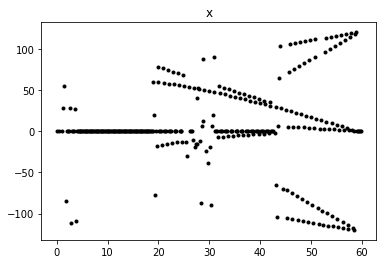

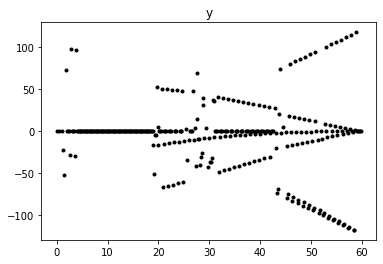

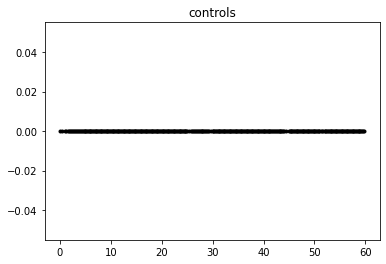

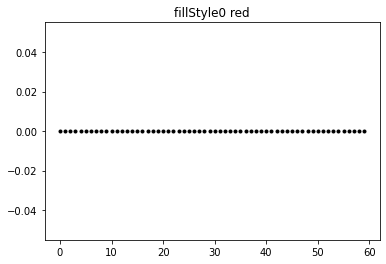

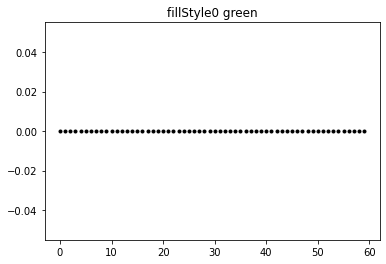

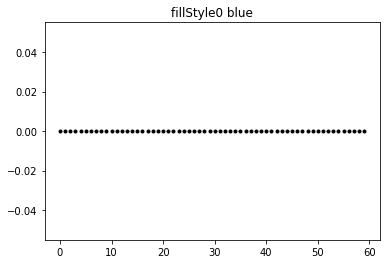

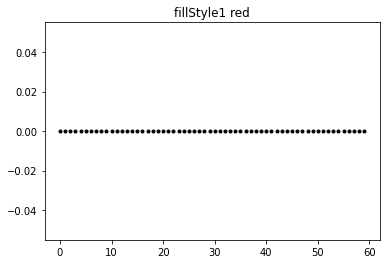

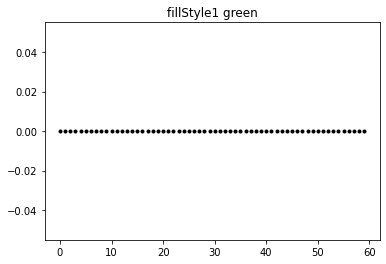

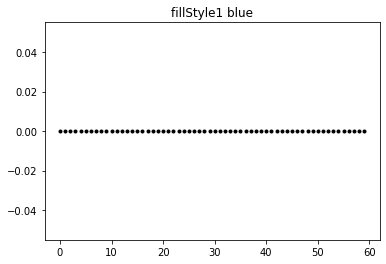

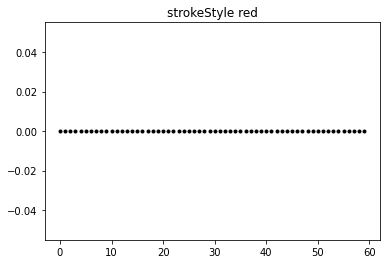

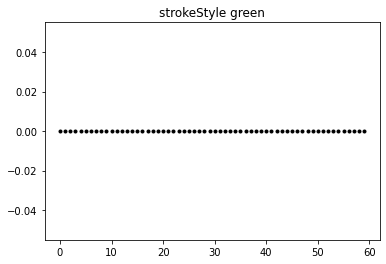

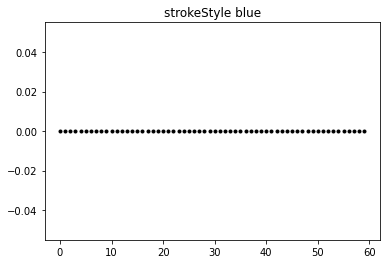

In [374]:
def interpolate_points(start, end, i, duration):
    sx, sy = start
    ex, ey = end
    frac = i / (duration - 1)
    return [(ex-sx)*frac + sx, (ey-sy)*frac + sy]

def interpolate_color_map(start, end, i, duration):
    result = {}
    for key in start:
        scol = start[key]
        ecol = end[key]
        result[key] = interpolate_color(scol, ecol, i, duration)
    return result
        

def _conv_style_index(index):
    if index == None:
        return None
    return int(index) + 1
    
def generate_tweens(tweenInfo):
    """ Accept tween data, return shape data"""
    duration = tweenInfo[0]['duration'] + 1
    segments = tweenInfo[0]['segments']
    hints = tweenInfo[0]['hints']
    initialShapes = tweenInfo[0]['shapes']
    finalShapes = tweenInfo[1]['shapes']
    
    truth = groundtruth(tweenInfo)
    print(truth[1])
    
    result = []
    for i in range(duration):
        assert len(tweenInfo[0]['shapes']) == 1
        newShape = {
            'fills': interpolate_color_map(
                tweenInfo[0]['shapes'][0]['fills'],
                tweenInfo[1]['shapes'][0]['fills'],
                i, duration),
            'strokes': interpolate_color_map(
                tweenInfo[0]['shapes'][0]['strokes'],
                tweenInfo[1]['shapes'][0]['strokes'],
                i, duration),
            'edges': []
        }
        result.append([newShape])
        for segment in segments[-1:]:
            newSegment = {
                'fillStyle0': None,
                'fillStyle1': _conv_style_index(segment['fillIndex1']),
                'strokeStyle': _conv_style_index(segment['strokeIndex1']),
                'points': [[]]
            }
            newShape['edges'].append(newSegment)

            newSegment['points'][0].append(interpolate_points(
                segment['startPointA'], segment['startPointB'], i, duration))
            for ctrlA, anchA, ctrlB, anchB, isLine in segment['curves']:
                if not isLine:
                    newSegment['points'][0].append((interpolate_points(
                        ctrlA, ctrlB, i, duration),))
                newSegment['points'][0].append(interpolate_points(
                    anchA, anchB, i, duration))
    result[0] = tweenInfo[0]['shapes']
    result[-1] = tweenInfo[1]['shapes']
    
    
    print('=== shapes ===')
    print(tweenInfo[0]['shapes'])
    print('=== segments ===')
    print(segments)
    print(len(segments[0]['curves']))
    print('=== hints ===')
    print(hints)
    print('=== initial ===')
    print(truth[0])
    print(result[0])
    print('=== second ===')
    print(truth[1])
    print(result[1])
    print('=== penultimate ===')
    print(truth[-2])
    print(result[-2])
    print('=== final ===')
    print(truth[-1])
    print(result[-1])
    
    # resultShapes = interpolate_shapes(initialShapes, finalShapes, duration+1)
    # compare_framesets(resultShapes, truth)
    # compare_shapes(resultShapes[0], truth[0])
    compare_framesets(result, truth)
    # compare_shapes(result[0], truth[0])
        
    
    
    # return frame['shapes']

    
# weird ground truth on:
# ... complex line tween

# failure on:
# ... none

# success on:
# ... shape and color tween
# ... segment tween
# ... hinted segment tween 2
# ... hinted curve tween
# ... complex shape tween
# ... simple curve tween
# ... hinted segment tween
# ... complex curve tween
# ... hinted shape tween
# ... simple shape tween
# ... polygon tween
print(data.keys())
# for key in data:
key = 'complex line tween'
print('checking', key)
tweenInfo = data[key]['tweenInfo']
generate_tweens(tweenInfo)

In [ ]:
print(data['simple shape tween']['tweenInfo'])

[{'testName': 'simple shape tween', 'index': 0, 'duration': 59, 'segments': [{'startPointA': [281.05, 252.95], 'startPointB': [793.6, 385.6], 'strokeIndex1': 0, 'strokeIndex2': 0, 'fillIndex1': None, 'fillIndex2': None, 'curves': [[[364.55, 252.95], [448.0, 252.95], [879.75, 335.85], [965.9, 286.1], 'true'], [[448.0, 317.45], [448.0, 381.95], [995.65, 337.65], [1025.4, 389.15], 'true'], [[364.55, 381.95], [281.05, 381.95], [939.25, 438.9], [853.1, 488.65], 'true'], [[281.05, 317.45], [281.05, 252.95], [823.35, 437.15], [793.6, 385.6], 'true']]}, {'startPointA': [281.05, 252.95], 'startPointB': [793.6, 385.6], 'strokeIndex1': 0, 'strokeIndex2': 0, 'fillIndex1': 0, 'fillIndex2': 0, 'curves': [[[364.55, 252.95], [448.0, 252.95], [879.75, 335.85], [965.9, 286.1], 'true'], [[448.0, 317.45], [448.0, 381.95], [995.65, 337.65], [1025.4, 389.15], 'true'], [[364.55, 381.95], [281.05, 381.95], [939.25, 438.9], [853.1, 488.65], 'true'], [[281.05, 317.45], [281.05, 252.95], [823.35, 437.15], [793.6

In [93]:
import shutil
from xflsvg import *

def sample_path(sample):
    return fr'C:\Users\synthbot\animate-tools\output\ShapeTweens\{sample}.xml'

def template_path(fn):
    return os.path.join(r'C:\Users\synthbot\animate-tools\output\Untitled-1', fn)

def convert_to_svg(sample):
    print('using', sample)
    shutil.copyfile(
        sample_path(f'truth-{sample}'),
        template_path('DOMDocument.xml'))

    xfl = XflReader(template)
    timeline = xfl.get_timeline()

    output_path = fr'C:\Users\synthbot\animate-tools\output\svgs\{sample}'
    os.makedirs(output_path, exist_ok=True)

    for i, frame in enumerate(timeline):
        with SvgRenderer() as renderer:
            frame.render()
        svg = renderer.compile(xfl.width, xfl.height)
        with open(fr'{output_path}\frame%03d.svg' % i, 'w') as outfile:
            svg.write(outfile, encoding='unicode')

for sample in data.keys():
    convert_to_svg(sample)

using hinted curve tween
file:///Untitled-1.xfl/Scene 1
using complex shape tween
file:///Untitled-1.xfl/Scene 1
using hinted segment tween 2
file:///Untitled-1.xfl/Scene 1
using shape and color tween
file:///Untitled-1.xfl/Scene 1
using segment tween
file:///Untitled-1.xfl/Scene 1
using hinted segment tween
file:///Untitled-1.xfl/Scene 1
using complex curve tween
file:///Untitled-1.xfl/Scene 1
using polygon tween
file:///Untitled-1.xfl/Scene 1
using complex line tween
file:///Untitled-1.xfl/Scene 1
using simple curve tween
file:///Untitled-1.xfl/Scene 1
using simple shape tween
file:///Untitled-1.xfl/Scene 1
using hinted shape tween
file:///Untitled-1.xfl/Scene 1


In [99]:
shutil.copyfile(sample_path('hinted shape tween'), template_path('DOMDocument.xml'))
data['complex shape tween']['tweenInfo']


[{'testName': 'complex shape tween',
  'index': 0,
  'duration': 59,
  'segments': [{'startPointA': [354.0, 341.95],
    'startPointB': [756.0, 312.95],
    'strokeIndex1': '0',
    'strokeIndex2': '0',
    'fillIndex1': None,
    'fillIndex2': None,
    'curves': [[[354.0, 317.5],
      [378.45, 300.2],
      [782.85, 312.95],
      [809.7, 312.95]],
     [[402.9, 282.95], [437.5, 282.95], [842.9, 312.95], [876.1, 312.95]],
     [[472.4, 283.15], [496.55, 300.2], [877.0, 346.2], [877.0, 379.45]],
     [[521.0, 317.5], [521.0, 341.95], [877.0, 406.7], [877.0, 433.95]],
     [[520.95, 366.45], [496.55, 383.65], [850.2, 433.95], [823.4, 433.95]],
     [[472.1, 400.95], [437.5, 400.95], [790.15, 433.95], [756.9, 433.95]],
     [[402.6, 400.75], [378.45, 383.65], [756.0, 400.7], [756.0, 367.45]],
     [[354.0, 366.4], [354.0, 341.95], [756.0, 340.2], [756.0, 312.95]]]},
   {'startPointA': [354.0, 341.95],
    'startPointB': [756.0, 312.95],
    'strokeIndex1': '0',
    'strokeIndex2': '0',